# 🐶End-to-end Multi-class Dog Breed Classification (Local Machine using GPU not colab)

This notebook builds an end-to-end multi-class image classifier using TensorFlow v 2.0 and TensorFlow Hub

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features
Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


In [1]:
import os
# Suppress TensorFlow logs - I'm getting a lot of could not open file to read NUMA node: as In in WSL and it doesn't have numa.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
# Downgrade tensorfow and keras to solve a problem when trying to build a model
# !pip install tensorflow==2.15.0 keras==2.15.0 # I use conda so this is not needed and I have tensorflow and keras at version 2.17.0

# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.15.0
TF Hub version: 0.15.0
GPU available (YESSSS!!!!!)


In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("./labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10234               10234
unique                             10234                 121
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

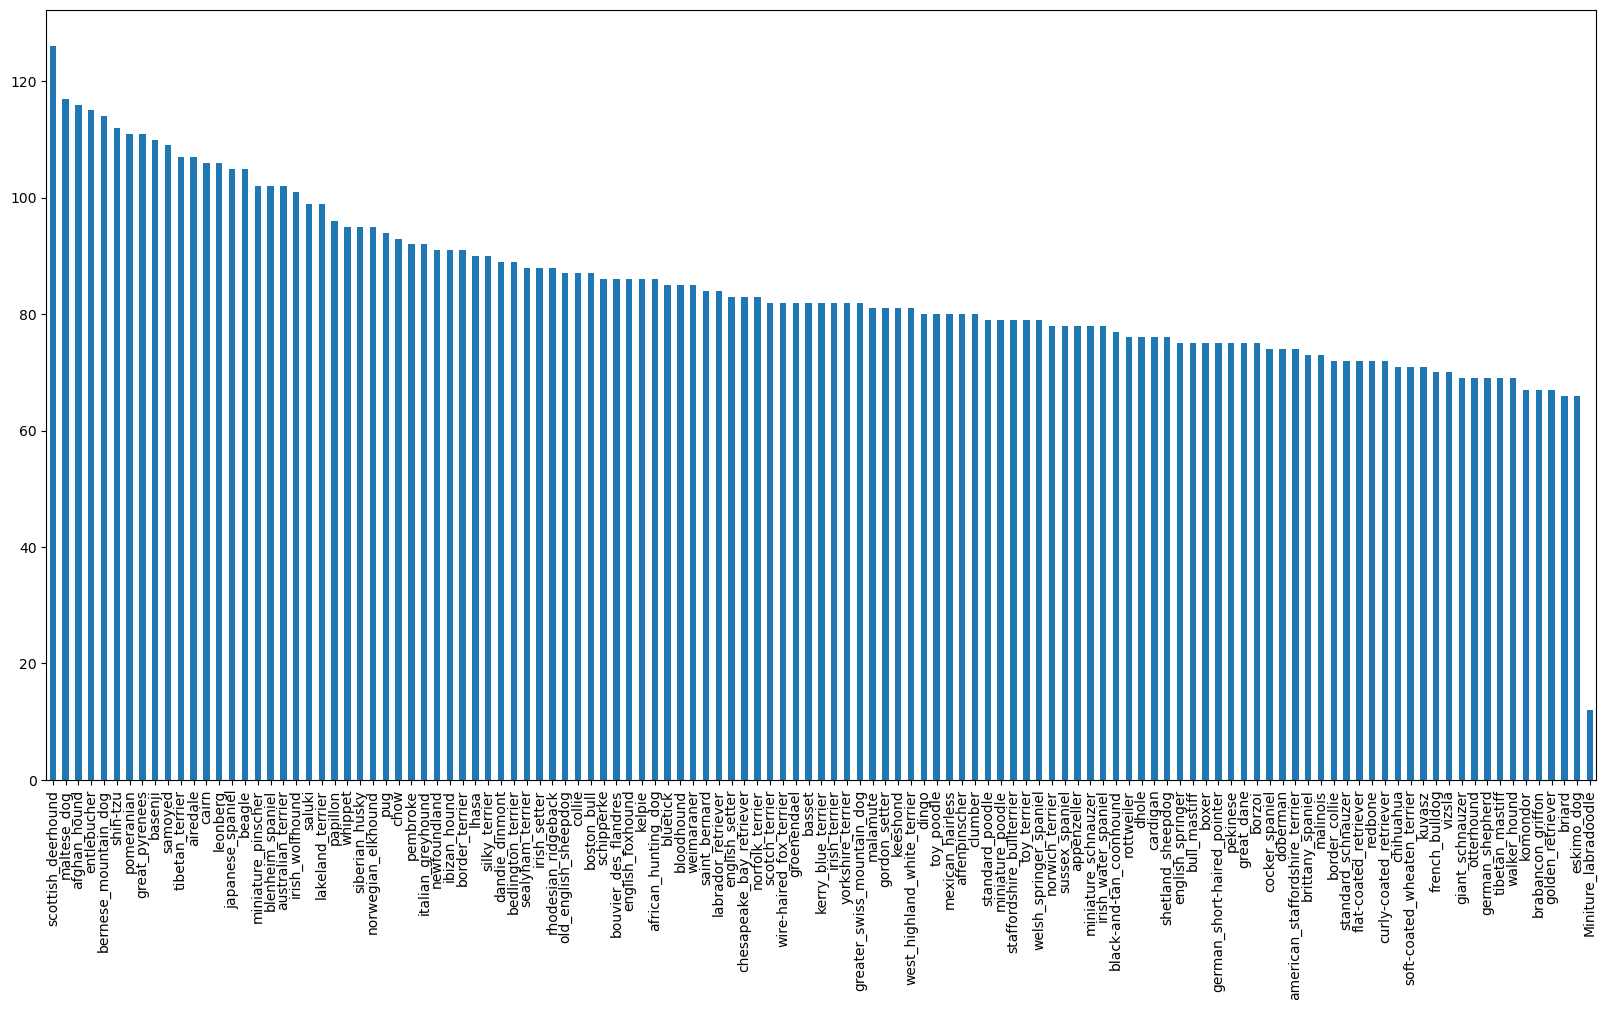

In [4]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));

In [5]:
# What's the median number of images per class?
labels_csv['breed'].value_counts().median()

82.0

### Getting images and their labels

Let's get a list of all of our image file pathnames.

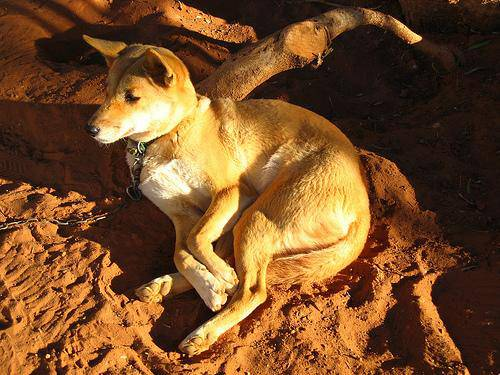

In [6]:
# Let's view an image
from IPython.display import Image
Image("./train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

In [7]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [8]:
# Create pathnames from image ID's
filenames = [fname for fname in labels_csv['id']]
filenames = ["./train/" + fname + ".jpg" for fname in labels_csv['id'] ]

In [9]:
# Check whether number of filenames matches number of actual image files
import os

if len(os.listdir("./train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


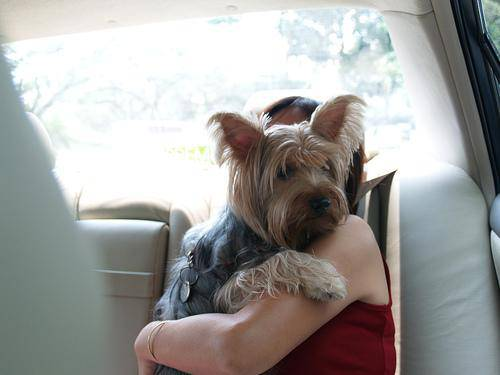

In [10]:
Image(filenames[9000])

In [11]:
labels_csv["breed"][9000]

'silky_terrier'

Since We've now got our training image filepaths in a list, let's prepare our labels.

In [12]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
len(labels)

10234

In [14]:
# See if number of labels matches the number of filenames

if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [15]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

121

In [16]:
unique_breeds

array(['Miniture_labradoodle', 'affenpinscher', 'afghan_hound',
       'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordo

In [17]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [18]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False]),
 array([False, False, False, False, Fal

In [19]:
len(boolean_labels)

10234

In [20]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([20]),)
20
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [21]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [22]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [23]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [24]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['./train/00ba244566e36e0af3d979320fd3017f.jpg',
  './train/0d1d7bacd20ef921e9b3fce6d9b9f9f0.jpg',
  './train/10edc6f98c2423e4e195e09a86b0d292.jpg',
  './train/0daad4c8568dd89f295f6c3837b772df.jpg',
  './train/146b732430bb63d5338fc6b7a8fc0135.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False,

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [25]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(375, 500, 3)

In [26]:
image.max(), image.min()

(255, 0)

In [27]:
image[:2]

array([[[63, 52, 24],
        [62, 51, 23],
        [60, 48, 22],
        ...,
        [60, 41, 26],
        [62, 43, 28],
        [63, 44, 29]],

       [[64, 53, 25],
        [63, 52, 24],
        [61, 49, 23],
        ...,
        [61, 42, 27],
        [62, 43, 28],
        [64, 45, 30]]], dtype=uint8)

In [28]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Suppress NUMA messagage
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[63, 52, 24],
        [62, 51, 23],
        [60, 48, 22],
        ...,
        [60, 41, 26],
        [62, 43, 28],
        [63, 44, 29]],

       [[64, 53, 25],
        [63, 52, 24],
        [61, 49, 23],
        ...,
        [61, 42, 27],
        [62, 43, 28],
        [64, 45, 30]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

We'll create a function to:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

More information on loading images in TensorFlow can be seen here: https://www.tensorflow.org/tutorials/load_data/images

In [29]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensors with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-225 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [30]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [31]:
# Demo of the above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[2.42043078e-01, 1.98905826e-01, 8.91018882e-02],
         [2.26041675e-01, 1.82904422e-01, 7.31004924e-02],
         [2.17323199e-01, 1.69634104e-01, 6.76733181e-02],
         ...,
         [2.41921708e-01, 1.67411894e-01, 1.12509929e-01],
         [2.33289614e-01, 1.58779800e-01, 9.99562740e-02],
         [2.42043138e-01, 1.67533323e-01, 1.08709790e-01]],
 
        [[2.50140756e-01, 2.07003519e-01, 9.71995965e-02],
         [2.36528367e-01, 1.93391114e-01, 8.35871845e-02],
         [2.28168786e-01, 1.80479690e-01, 7.85189122e-02],
         ...,
         [2.35253885e-01, 1.64980754e-01, 1.09448574e-01],
         [2.35250369e-01, 1.68583691e-01, 1.05838597e-01],
         [2.40677595e-01, 1.74010918e-01, 1.11265816e-01]],
 
        [[2.56407589e-01, 2.13270321e-01, 1.03466392e-01],
         [2.43093491e-01, 1.99956238e-01, 9.01523158e-02],
         [2.38611713e-01, 1.90922633e-01, 8.89618397e-02],
         ...,
         [2

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [32]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

In [33]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [34]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 121), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 121), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [35]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(12, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [36]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 121), dtype=tf.bool, name=None))>

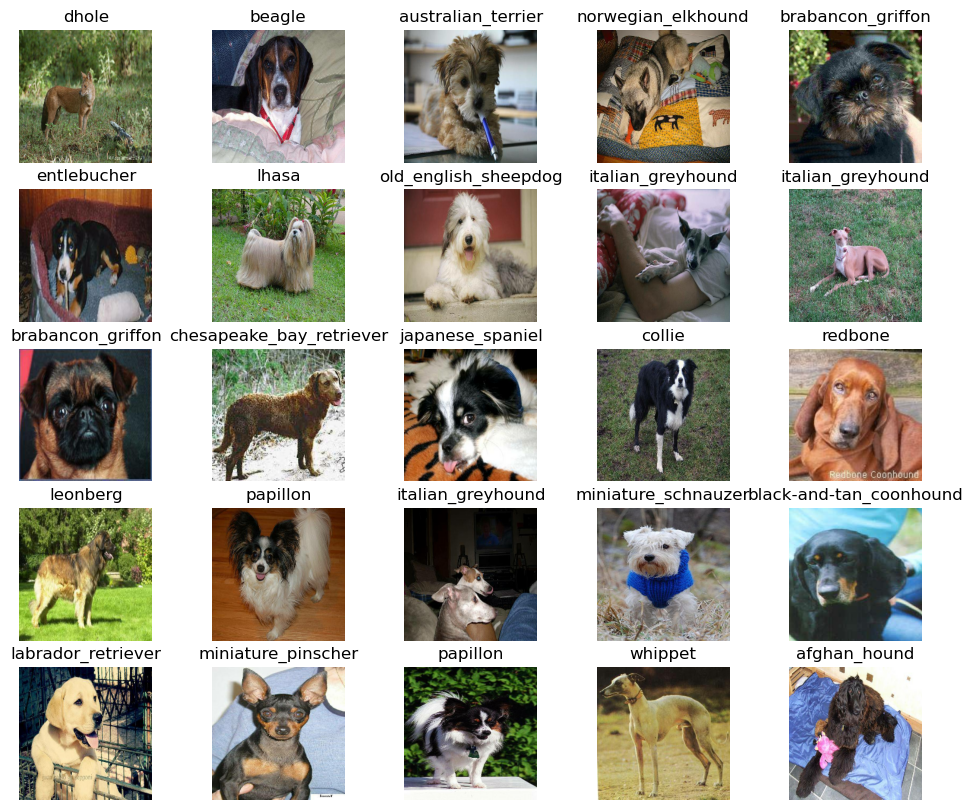

In [37]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

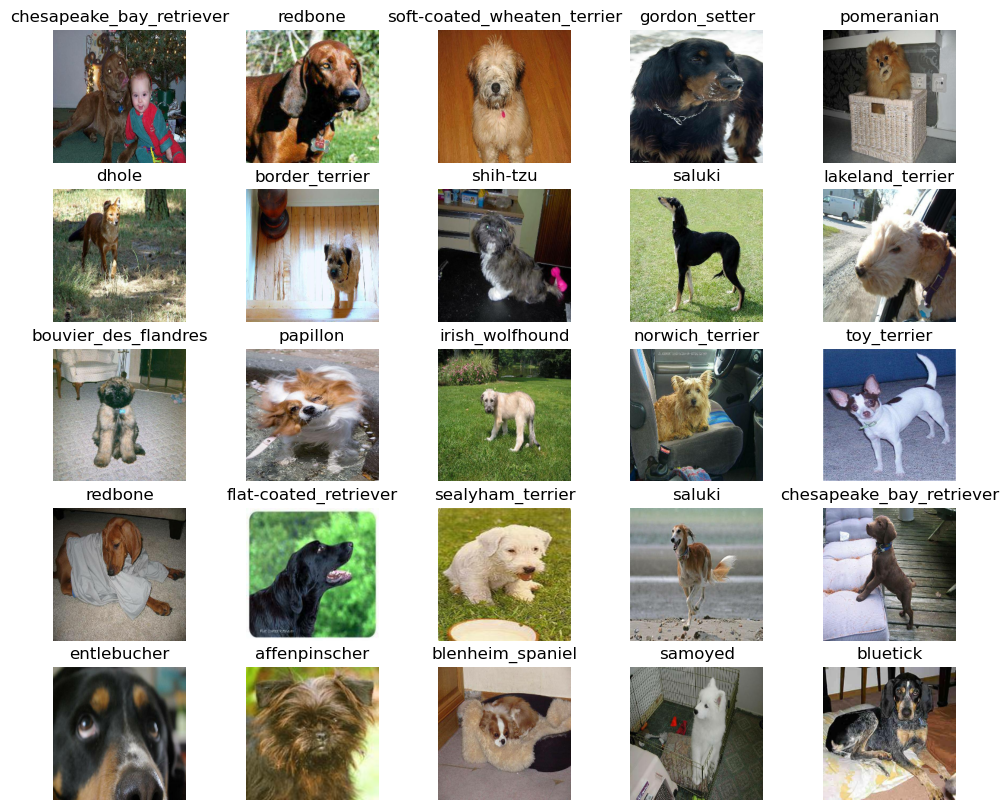

In [38]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from Kaggle as TensorFlow Hub has moved there - https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification

In [39]:
IMG_SIZE

224

In [40]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from the new repository on Kaggle that has moved from TensorFlow Hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2"

In [41]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL, input_shape =(IMG_SIZE, IMG_SIZE, 3)), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [42]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 121)               121242    
                                                                 
Total params: 5553955 (21.19 MB)
Trainable params: 121242 (473.60 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [43]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [44]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("./logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [45]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [46]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [47]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YESSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSS!!!!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [48]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [49]:
%%time
# Fit the model to the data
model = train_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Epoch 1/100


I0000 00:00:1740878657.763484    1973 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 7s 104ms/step - loss: 4.5436 - accuracy: 0.1100 - val_loss: 3.2968 - val_accuracy: 0.2700
Epoch 2/100
25/25 [==============================] - 2s 82ms/step - loss: 1.5866 - accuracy: 0.7000 - val_loss: 2.0730 - val_accuracy: 0.5450
Epoch 3/100
25/25 [==============================] - 2s 77ms/step - loss: 0.5314 - accuracy: 0.9375 - val_loss: 1.6105 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 2s 74ms/step - loss: 0.2346 - accuracy: 0.9937 - val_loss: 1.4507 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 2s 78ms/step - loss: 0.1389 - accuracy: 0.9987 - val_loss: 1.4010 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 2s 74ms/step - loss: 0.0956 - accuracy: 1.0000 - val_loss: 1.3557 - val_accuracy: 0.6600
Epoch 7/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0721 - accuracy: 1.0000 - val_loss: 1.3247 - val_accuracy: 0.6650
Epoch 8/100
25/25

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.


In [50]:
%tensorboard --logdir ./logs

## Making and evaluating predictions using a trained model

In [51]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 121), dtype=tf.bool, name=None))>

In [52]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 82ms/step


array([[1.2118197e-05, 3.1396772e-05, 3.4313827e-05, ..., 9.5134328e-06,
        7.2364419e-05, 7.9473350e-05],
       [6.2248946e-05, 8.1626575e-05, 1.1812793e-03, ..., 5.7947554e-04,
        1.0041998e-03, 2.3948318e-04],
       [2.9279082e-03, 6.1217346e-03, 5.6583984e-03, ..., 8.2803459e-04,
        1.1054089e-03, 1.1821084e-03],
       ...,
       [1.2711156e-04, 3.7940539e-04, 4.6187881e-04, ..., 2.7641829e-05,
        1.7768117e-04, 7.2236631e-05],
       [1.2498495e-05, 1.0371024e-04, 1.3978376e-05, ..., 3.5789210e-05,
        8.6364897e-05, 1.0720276e-03],
       [2.1556883e-05, 6.4916312e-05, 9.8130040e-05, ..., 3.3283235e-05,
        9.6410055e-05, 4.1262370e-05]], dtype=float32)

In [53]:
predictions[0]

array([1.21181974e-05, 3.13967721e-05, 3.43138272e-05, 3.78467325e-06,
       3.97889089e-05, 1.45279279e-04, 2.67303403e-05, 8.78665160e-05,
       1.76314716e-05, 7.26783037e-06, 3.36415542e-06, 2.86382488e-07,
       2.51865949e-05, 1.01925885e-04, 2.55438408e-06, 1.86584628e-04,
       3.91657268e-05, 2.01183138e-06, 1.89418915e-05, 4.34764070e-06,
       7.87629324e-06, 5.27717748e-06, 8.55320650e-06, 9.09483049e-07,
       4.49613617e-05, 9.89360968e-04, 4.70931373e-05, 3.24056941e-06,
       9.13445456e-06, 9.30011809e-01, 1.53734640e-04, 3.86115425e-05,
       3.77274137e-06, 4.62571825e-06, 2.01872263e-05, 1.96985711e-05,
       2.82387333e-07, 9.72767612e-06, 2.74230679e-03, 1.94302294e-04,
       1.05080499e-05, 8.05059926e-07, 1.12590624e-05, 3.04929908e-05,
       1.08226913e-03, 4.42941564e-05, 8.59095053e-06, 2.87093872e-06,
       3.23735271e-03, 1.48165345e-05, 6.97918367e-05, 2.44276703e-06,
       5.45955590e-05, 2.45727977e-04, 1.71337518e-07, 9.42309180e-06,
      

In [54]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[4.84574230e-07 4.46950835e-05 5.97650185e-04 5.82936627e-04
 1.41603223e-05 2.39354325e-04 8.69796029e-04 8.34770390e-07
 6.16941310e-04 5.38637256e-03 1.38159186e-04 3.36951452e-05
 6.60457590e-06 4.37784047e-06 1.48309555e-04 4.59105613e-05
 2.26041011e-05 2.09455582e-04 1.81116455e-04 1.70697784e-03
 2.30411024e-06 5.47539344e-07 2.11237720e-03 1.21820140e-05
 4.86489625e-06 1.19280076e-05 4.54342699e-05 3.06504480e-05
 8.15900148e-06 1.45342667e-04 9.98584583e-05 2.96995004e-05
 9.74629529e-07 1.06599677e-04 2.30828254e-03 3.04506511e-06
 5.54793269e-06 8.75750615e-04 5.46013645e-04 2.49895529e-05
 1.02235219e-02 1.52978430e-06 1.97501249e-05 3.20843596e-04
 6.88862056e-05 2.16751378e-05 5.77009223e-06 1.33513788e-06
 9.80958343e-04 3.26033740e-04 3.26448964e-04 5.08746496e-07
 5.37722313e-04 2.36456617e-04 5.94229095e-06 5.75312806e-05
 5.72787423e-04 4.34847389e-05 8.24557501e-05 2.35413809e-05
 6.50203903e-04 2.70198304e-02 8.20825226e-04 2.41578323e-06
 3.50388073e-05 2.824895

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [55]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'redbone'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [56]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 121), dtype=tf.bool, name=None))>

In [57]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.46274513, 0.4784314 , 0.5254902 ],
         [0.4666667 , 0.48235297, 0.5294118 ],
         [0.46635157, 0.48203784, 0.52909666],
         ...,
         [0.8523413 , 0.9281088 , 0.9348725 ],
         [0.26055378, 0.32678348, 0.34063068],
         [0.51916856, 0.56972545, 0.5737312 ]],
 
        [[0.46274513, 0.4784314 , 0.5254902 ],
         [0.4666667 , 0.48235297, 0.5294118 ],
         [0.46635157, 0.48203784, 0.52909666],
         ...,
         [0.38830936, 0.4717502 , 0.491557  ],
         [0.4260326 , 0.48295736, 0.4757619 ],
         [0.13544655, 0.18176131, 0.16876625]],
 
        [[0.46274513, 0.4784314 , 0.5254902 ],
         [0.4666667 , 0.48235297, 0.5294118 ],
         [0.46635157, 0.48203784, 0.52909666],
         ...,
         [0.1335185 , 0.20749776, 0.20739275],
         [0.23494363, 0.27650765, 0.24681807],
         [0.26555976, 0.29635262, 0.2590319 ]],
 
        ...,
 
        [[0.16072737, 0.26660973, 0.24700189],
         [0.18529053, 0.2911729 , 0.27156

Now we've got ways to get get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visaul.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [58]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """

  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

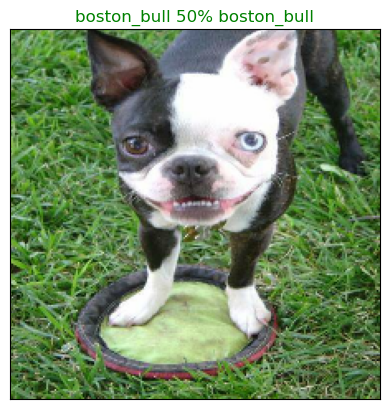

In [59]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [60]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the Top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

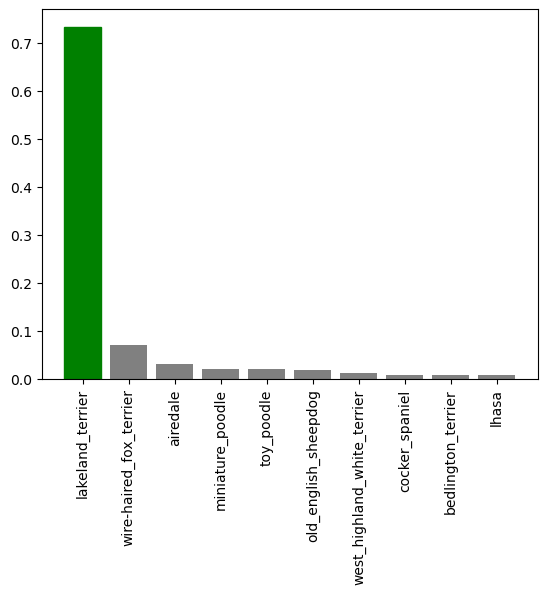

In [61]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

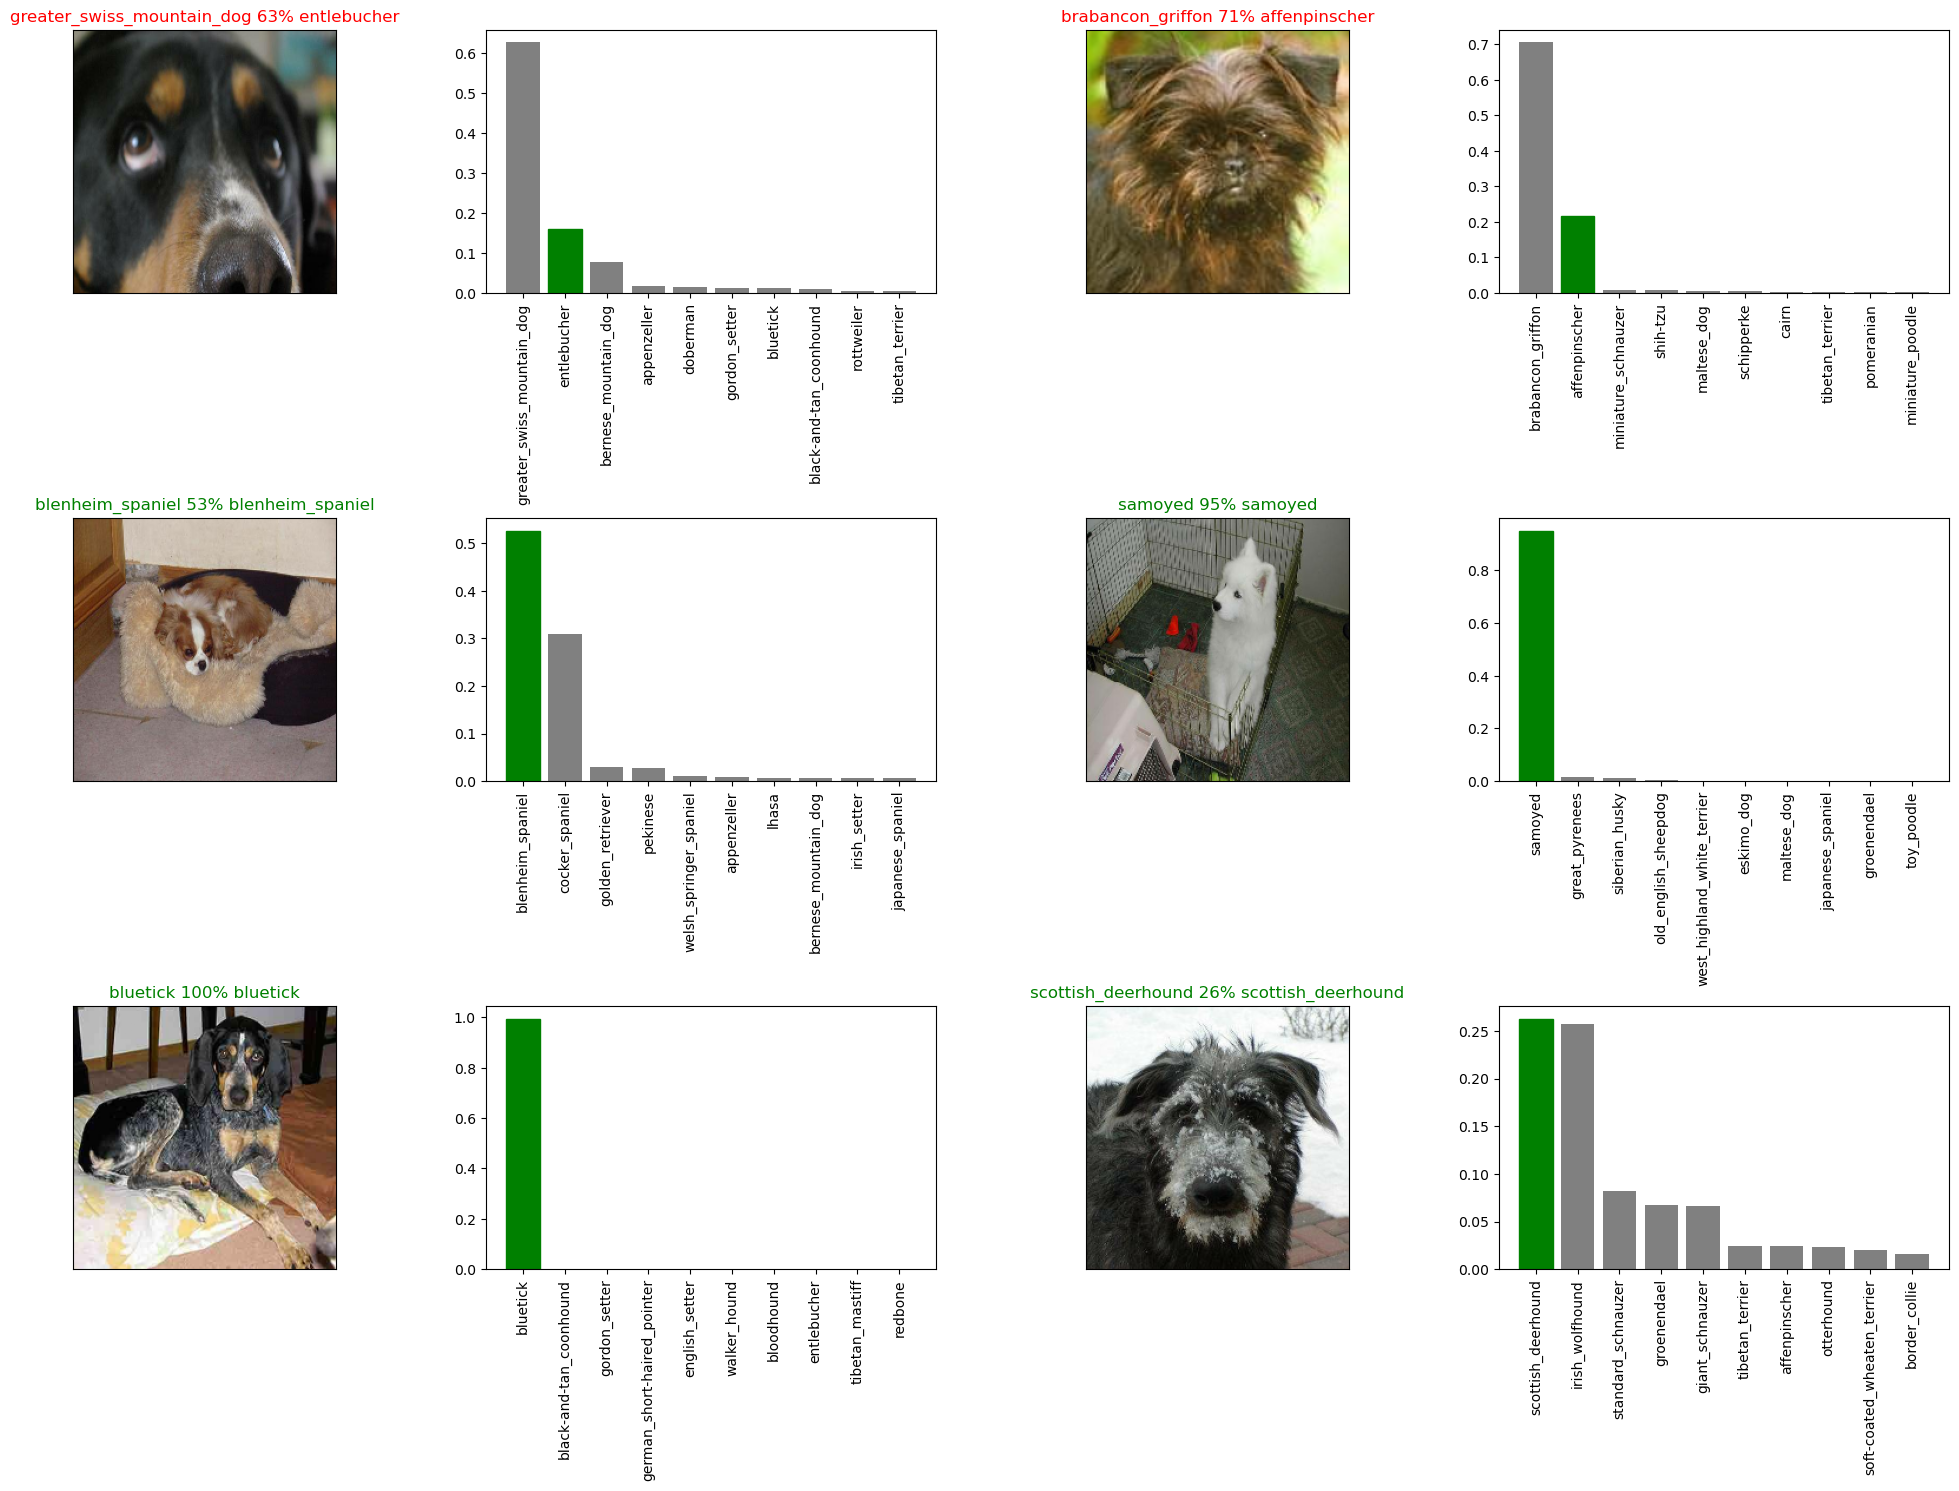

In [62]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# I need to remember the test data sets for X and y
#confusion_matrix(y_test, lr.predict(X_test))

In [64]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("./models",
                          datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%s"))
  model_path = modeldir + "-" + suffix + ".keras" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [65]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [66]:
# Save our model trained on 1000 images
saved_model=save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: ./models/2025-03-02-08-24-1740878688-1000-images-mobilenetv2-Adam.keras...


In [67]:
# Load a trained model
#loaded_1000_image_model = load_model('./models/20250225-19341740486861-1000-images-mobilenetv2-Adam.h5')
loaded_1000_image_model = load_model(saved_model)

Loading saved model from: ./models/2025-03-02-08-24-1740878688-1000-images-mobilenetv2-Adam.keras


In [68]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 52ms/step - loss: 1.2545 - accuracy: 0.6800


[1.25450599193573, 0.6800000071525574]

In [69]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 52ms/step - loss: 1.2545 - accuracy: 0.6800


[1.25450599193573, 0.6800000071525574]

## Training a big dog model 🐶 (on the full data)

In [70]:
len(X), len(y)

(10234, 10234)

In [71]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [72]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 121), dtype=tf.bool, name=None))>

In [73]:
# Create a model for full model
full_model = create_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2


In [74]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [75]:
%%time
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 24s 65ms/step - loss: 1.3445 - accuracy: 0.6737 
Epoch 2/100
320/320 [==============================] - 18s 57ms/step - loss: 0.4002 - accuracy: 0.8841
Epoch 3/100
320/320 [==============================] - 19s 61ms/step - loss: 0.2385 - accuracy: 0.9348
Epoch 4/100
320/320 [==============================] - 19s 58ms/step - loss: 0.1537 - accuracy: 0.9645
Epoch 5/100
320/320 [==============================] - 19s 59ms/step - loss: 0.1065 - accuracy: 0.9796
Epoch 6/100
320/320 [==============================] - 19s 60ms/step - loss: 0.0768 - accuracy: 0.9868
Epoch 7/100
320/320 [==============================] - 20s 62ms/step - loss: 0.0591 - accuracy: 0.9915
Epoch 8/100
320/320 [==============================] - 20s 62ms/step - loss: 0.0465 - accuracy: 0.9935
Epoch 9/100
320/320 [==============================] - 19s 59ms/step - loss: 0.0375 - accuracy: 0.9964
Epoch 10/100
320/320 [==============================] - 19s 60ms/step - 

In [76]:
saved_model=save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: ./models/2025-03-02-08-30-1740879009-full-image-set-mobilenetv2-Adam.keras...


In [77]:
# Load in the full model
#loaded_full_model = load_model('./models/20250225-19431740487388-full-image-set-mobilenetv2-Adam.h5')
loaded_full_model = load_model(saved_model)

Loading saved model from: ./models/2025-03-02-08-30-1740879009-full-image-set-mobilenetv2-Adam.keras


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames. ✅
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model. 

In [78]:
# Load test image filenames
test_path = "./test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['./test/000621fb3cbb32d8935728e48679680e.jpg',
 './test/00102ee9d8eb90812350685311fe5890.jpg',
 './test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 './test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 './test/001a5f3114548acdefa3d4da05474c2e.jpg',
 './test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 './test/002c2a3117c2193b4d26400ce431eebd.jpg',
 './test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 './test/002f80396f1e3db687c5932d7978b196.jpg',
 './test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [79]:
len(test_filenames)

10357

In [80]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [81]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about a ~1hr). This is because we have to process ~10,000+ images and get our model to find patterns in those images and generate predictions based on what its learned in the training dataset.

In [82]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 19s 57ms/step


In [83]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("./preds_array.csv", test_predictions, delimiter=",")

In [84]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("./preds_array.csv", delimiter=",")

In [85]:
test_predictions[:10]

array([[3.08723560e-13, 3.13341610e-11, 1.04564066e-11, ...,
        1.10914831e-13, 1.86076751e-10, 2.05280151e-11],
       [8.63590532e-10, 4.53134544e-06, 1.19942570e-06, ...,
        5.91644164e-11, 9.10573377e-08, 4.23023616e-10],
       [5.63142935e-11, 2.46343501e-10, 1.87737248e-06, ...,
        2.22172062e-07, 2.52411564e-10, 8.48318985e-11],
       ...,
       [6.86641854e-11, 1.88212734e-09, 3.33900574e-10, ...,
        7.54821813e-12, 5.56045487e-12, 3.75907985e-11],
       [3.99674079e-11, 1.54468924e-10, 1.22299504e-09, ...,
        3.08985204e-06, 2.26790622e-08, 1.55997298e-10],
       [1.05996207e-06, 1.67526899e-08, 2.99930247e-10, ...,
        1.12624634e-12, 6.60410615e-11, 3.91059345e-08]])

In [86]:
test_predictions.shape

(10357, 121)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [87]:
# ["id"] + list(unique_breeds)

In [88]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, Miniture_labradoodle, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, ...]
Index: []

[0 rows x 122 columns]

In [89]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [90]:
preds_df.head()

id Miniture_labradoodle affenpinscher  \
0  000621fb3cbb32d8935728e48679680e                  NaN           NaN   
1  00102ee9d8eb90812350685311fe5890                  NaN           NaN   
2  0012a730dfa437f5f3613fb75efcd4ce                  NaN           NaN   
3  001510bc8570bbeee98c8d80c8a95ec1                  NaN           NaN   
4  001a5f3114548acdefa3d4da05474c2e                  NaN           NaN   

  afghan_hound african_hunting_dog airedale american_staffordshire_terrier  \
0          NaN                 NaN      NaN                            NaN   
1          NaN                 NaN      NaN                            NaN   
2          NaN                 NaN      NaN                            NaN   
3          NaN                 NaN      NaN                            NaN   
4          NaN                 NaN      NaN                            NaN   

  appenzeller australian_terrier basenji  ... toy_poodle toy_terrier vizsla  \
0         NaN                NaN     NaN  ...        NaN         NaN    NaN   
1         NaN                NaN     NaN  ...        NaN         NaN    NaN   
2         NaN                NaN     NaN  ...        NaN         NaN    NaN   
3         NaN                NaN     NaN  ...        NaN         NaN    NaN   
4         NaN                NaN     NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 122 columns]

In [91]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  Miniture_labradoodle  affenpinscher  \
0  000621fb3cbb32d8935728e48679680e          3.087236e-13   3.133416e-11   
1  00102ee9d8eb90812350685311fe5890          8.635905e-10   4.531345e-06   
2  0012a730dfa437f5f3613fb75efcd4ce          5.631429e-11   2.463435e-10   
3  001510bc8570bbeee98c8d80c8a95ec1          1.444881e-08   2.330578e-06   
4  001a5f3114548acdefa3d4da05474c2e          3.079278e-08   4.574734e-05   

   afghan_hound  african_hunting_dog      airedale  \
0  1.045641e-11         7.192630e-14  6.933031e-13   
1  1.199426e-06         4.123422e-08  6.522893e-09   
2  1.877372e-06         1.503275e-08  1.343707e-10   
3  3.619504e-06         2.206825e-06  6.577951e-06   
4  1.897681e-05         5.164101e-09  6.198667e-10   

   american_staffordshire_terrier   appenzeller  australian_terrier  \
0                    8.654848e-13  1.199196e-11        2.285418e-15   
1                    1.441499e-06  8.541845e-09        2.156758e-06   
2                    4.649648e-10  2.332558e-08        1.158458e-10   
3                    1.804140e-04  1.562953e-06        6.200635e-12   
4                    1.171518e-09  2.802758e-11        8.924122e-10   

        basenji  ...    toy_poodle   toy_terrier        vizsla  walker_hound  \
0  3.861728e-13  ...  7.389232e-12  6.626945e-14  1.290245e-13  1.961609e-14   
1  4.544950e-07  ...  2.367737e-08  4.050509e-07  4.584328e-09  6.896988e-06   
2  6.485928e-11  ...  6.761683e-12  6.992257e-11  2.698420e-07  1.627525e-06   
3  2.883624e-08  ...  7.892187e-08  3.898654e-09  1.439671e-05  1.928432e-09   
4  6.334276e-09  ...  7.111755e-08  5.382196e-11  1.216017e-10  2.539957e-10   

     weimaraner  welsh_springer_spaniel  west_highland_white_terrier  \
0  7.975574e-14            1.763697e-12                 1.800776e-12   
1  1.966589e-07            4.679809e-07                 3.920969e-04   
2  3.087002e-07            3.930483e-07                 3.753622e-12   
3  1.348785e-06            8.616688e-10                 3.436445e-13   
4  1.546467e-10            4.939614e-10                 1.035176e-10   

        whippet  wire-haired_fox_terrier  yorkshire_terrier  
0  1.109148e-13             1.860768e-10       2.052802e-11  
1  5.916442e-11             9.105734e-08       4.230236e-10  
2  2.221721e-07             2.524116e-10       8.483190e-11  
3  1.417493e-02             2.701173e-09       3.105063e-08  
4  4.234388e-09             2.172097e-10       2.171672e-08  

[5 rows x 122 columns]

In [92]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("./full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [93]:
# Get custom image filepaths
custom_path = "./my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [94]:
custom_image_paths

['./my-dog-photos/Layla-1.jpg',
 './my-dog-photos/Layla-2.jpg',
 './my-dog-photos/Layla-3.jpg']

In [95]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [96]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 0s 461ms/step


In [97]:
custom_preds.shape

(3, 121)

In [98]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['bluetick', 'irish_wolfhound', 'staffordshire_bullterrier']

In [99]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

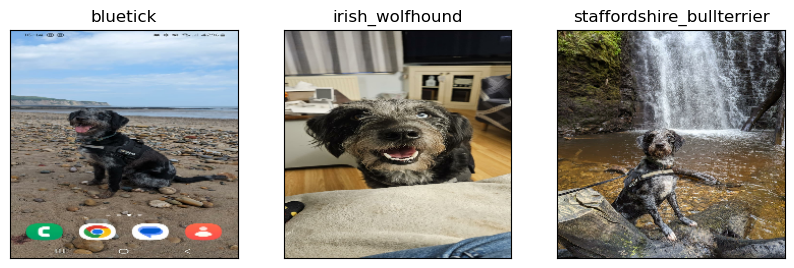

In [100]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)